In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## olist_customers_dataset


In [64]:
base_path = r"C:\Users\Reda\Documents\ANALYTICS\Data"

df_Customer = pd.read_csv(f"{base_path}\\olist_customers_dataset.csv")
products = pd.read_csv(f"{base_path}\\olist_products_dataset.csv")
df_seller = pd.read_csv(f"{base_path}\\olist_sellers_dataset.csv")
category_translation = pd.read_csv(f"{base_path}\\product_category_name_translation.csv")
orders = pd.read_csv(f"{base_path}\\olist_orders_dataset.csv")
df_order_payments = pd.read_csv(f"{base_path}\\olist_order_payments_dataset.csv")
df_order_items = pd.read_csv(f"{base_path}\\olist_order_items_dataset.csv")
df_order_reviews = pd.read_csv(f"{base_path}\\olist_order_reviews_dataset.csv")

# Conversion des dates
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])

In [65]:
orders["order_month"] = orders["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()
orders_clean = orders[["order_id", "order_month", "order_purchase_timestamp"]]

# Fusion initiale
df = df_order_items.merge(orders_clean, on="order_id", how="left")
df = df.merge(products, on="product_id", how="left")
df = df.merge(category_translation, on="product_category_name", how="left")


In [66]:
# Agrégation des paiements
payment_agg = df_order_payments.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_installments': 'mean'
}).reset_index()
df = df.merge(payment_agg, on='order_id', how='left')

# Agrégation des reviews
review_agg = df_order_reviews.groupby('order_id').agg({
    'review_score': 'mean'
}).reset_index()
df = df.merge(review_agg, on='order_id', how='left')

print("✓ Données fusionnées")

✓ Données fusionnées


## olist_products_dataset

In [67]:
monthly_sales = (
    df.groupby(["product_id", "order_month"])
      .agg({
          'order_id': 'count',
          'price': 'mean',
          'freight_value': 'mean',
          'payment_value': 'mean',
          'payment_installments': 'mean',
          'review_score': 'mean'
      })
      .reset_index()
      .rename(columns={'order_id': 'quantity_sold'})
)

# Ajouter caractéristiques produit
product_features = products[[
    "product_id", "product_category_name",
    "product_weight_g", "product_length_cm",
    "product_height_cm", "product_width_cm"
]]
monthly_sales = monthly_sales.merge(product_features, on="product_id", how="left")

In [68]:
monthly_sales["product_volume_cm3"] = (
    monthly_sales["product_length_cm"] *
    monthly_sales["product_height_cm"] *
    monthly_sales["product_width_cm"]
)

monthly_sales["product_density"] = (
    monthly_sales["product_weight_g"] / 
    monthly_sales["product_volume_cm3"].replace(0, np.nan)
)

# Ratio prix
monthly_sales["price_freight_ratio"] = (
    monthly_sales["price"] / 
    monthly_sales["freight_value"].replace(0, np.nan)
)

monthly_sales["price_per_kg"] = (
    monthly_sales["price"] / 
    (monthly_sales["product_weight_g"] / 1000).replace(0, np.nan)
)

## olist_sellers_dataset

In [69]:
monthly_sales["month"] = monthly_sales["order_month"].dt.month
monthly_sales["year"] = monthly_sales["order_month"].dt.year
monthly_sales["quarter"] = monthly_sales["order_month"].dt.quarter

# Encodage cyclique du mois
monthly_sales['month_sin'] = np.sin(2 * np.pi * monthly_sales['month'] / 12)
monthly_sales['month_cos'] = np.cos(2 * np.pi * monthly_sales['month'] / 12)

In [70]:
def get_season(m):
    if m in [12, 1, 2]: return 0  # été
    if m in [3, 4, 5]: return 1   # automne
    if m in [6, 7, 8]: return 2   # hiver
    return 3                       # printemps

monthly_sales["season"] = monthly_sales["month"].apply(get_season)

In [71]:
monthly_sales["is_black_friday"] = ((monthly_sales["month"] == 11)).astype(int)
monthly_sales["is_christmas"] = (monthly_sales["month"] == 12).astype(int)
monthly_sales["is_end_year"] = monthly_sales["month"].isin([11, 12]).astype(int)

## product_category_name_translation

In [72]:
monthly_sales["cumulative_sales_past"] = (
    monthly_sales.groupby("product_id")["quantity_sold"]
    .shift(1)
    .fillna(0)
    .groupby(monthly_sales["product_id"])
    .cumsum()
)

In [73]:
for lag in [1, 2, 3, 6, 12]:
    monthly_sales[f"lag_{lag}"] = (
        monthly_sales.groupby("product_id")["quantity_sold"].shift(lag)
    )

# Moyennes mobiles (utilisant les données passées uniquement)
for window in [3, 6, 12]:
    monthly_sales[f"rolling_mean_{window}"] = (
        monthly_sales.groupby("product_id")["quantity_sold"]
        .shift(1)
        .rolling(window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    monthly_sales[f"rolling_std_{window}"] = (
        monthly_sales.groupby("product_id")["quantity_sold"]
        .shift(1)
        .rolling(window, min_periods=1)
        .std()
        .reset_index(level=0, drop=True)
    )

# Coefficient de variation
monthly_sales["cv_3m"] = (
    monthly_sales["rolling_std_3"] / 
    (monthly_sales["rolling_mean_3"] + 1e-6))

In [74]:
def calculate_trend(series):
    if len(series) < 2:
        return 0
    return np.polyfit(range(len(series)), series, 1)[0]

monthly_sales["trend_3m"] = (
    monthly_sales.groupby("product_id")["quantity_sold"]
    .shift(1)
    .rolling(3, min_periods=2)
    .apply(calculate_trend, raw=False)
    .reset_index(level=0, drop=True))

In [75]:
monthly_sales = monthly_sales.sort_values(["product_category_name", "order_month"])

monthly_sales["category_avg_sales"] = (
    monthly_sales.groupby("product_category_name")["quantity_sold"]
    .transform(lambda x: x.shift(1).expanding().mean())
)

monthly_sales["category_std_sales"] = (
    monthly_sales.groupby("product_category_name")["quantity_sold"]
    .transform(lambda x: x.shift(1).expanding().std())
)

# Ratio par rapport à la catégorie (utilise les stats passées)
monthly_sales["sales_vs_category"] = (
    monthly_sales["quantity_sold"] / 
    (monthly_sales["category_avg_sales"] + 1e-6)
)

# Nombre total de mois de présence
monthly_sales["product_age_months"] = (
    monthly_sales.groupby("product_id").cumcount() + 1
)

# Ventes cumulées
monthly_sales["cumulative_sales"] = (
    monthly_sales.groupby("product_id")["quantity_sold"].cumsum()
)

# Moyenne des ventes depuis le début
monthly_sales["lifetime_avg_sales"] = (
    monthly_sales["cumulative_sales"] / monthly_sales["product_age_months"]
)

# Indicateur si le produit avait des ventes l'année dernière
monthly_sales["had_sales_last_year"] = (monthly_sales["lag_12"] > 0).astype(int)

# Ratio ventes actuelles / moyennes historiques
monthly_sales["sales_vs_lifetime_avg"] = (
    monthly_sales["quantity_sold"] / 
    (monthly_sales["lifetime_avg_sales"] + 1e-6)
)

In [76]:

monthly_sales["rolling3_x_trend"] = monthly_sales["rolling_mean_3"] * monthly_sales["trend_3m"].fillna(0)
monthly_sales["price_x_volume"] = monthly_sales["price"] * monthly_sales["product_volume_cm3"]

In [77]:
monthly_sales.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remplir les NaN dans les features numériques
numeric_cols = monthly_sales.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != 'quantity_sold':
        monthly_sales[col] = monthly_sales[col].fillna(0)


final_dataset = monthly_sales.dropna(subset=['quantity_sold']).reset_index(drop=True)


## olist_orders_dataset

In [78]:
cutoff_date = '2017-11-01'
train_data = final_dataset[final_dataset['order_month'] < cutoff_date].copy()
test_data = final_dataset[final_dataset['order_month'] >= cutoff_date].copy()

print(f"Train: {len(train_data):,} échantillons ({train_data['order_month'].min()} à {train_data['order_month'].max()})")
print(f"Test:  {len(test_data):,} échantillons ({test_data['order_month'].min()} à {test_data['order_month'].max()})")

Train: 21,199 échantillons (2016-09-01 00:00:00 à 2017-10-01 00:00:00)
Test:  40,977 échantillons (2017-11-01 00:00:00 à 2018-09-01 00:00:00)


In [79]:
exclude_cols = [
    'quantity_sold',        # Target
    'order_month',          # Date (déjà encodée)
    'product_id',           # Trop de cardinalité
    'product_category_name' # Sera encodé autrement
    
]

In [80]:
feature_cols = [col for col in final_dataset.columns if col not in exclude_cols]

X_train = train_data[feature_cols].copy()
y_train = train_data['quantity_sold'].copy()

X_test = test_data[feature_cols].copy()
y_test = test_data['quantity_sold'].copy()

print(f"\nFeatures utilisées: {len(feature_cols)}")
print(f"Exemples: {feature_cols[:10]}")


Features utilisées: 46
Exemples: ['price', 'freight_value', 'payment_value', 'payment_installments', 'review_score', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_volume_cm3']


## olist_order_payments_dataset

In [81]:


# Utiliser la version clippée pour l'entraînement
y_train_final = y_train

In [82]:

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ============================================================================ 
# 1. SÉLECTION DES FEATURES
# ============================================================================
exclude_cols = ['quantity_sold', 'some_other_cols','product_category_name','order_month','product_id','payment_installments','product_length_cm','product_height_cm','product_width_cm','price_x_volume','rolling3_x_trend']  # à adapter selon ton dataset
feature_cols = [col for col in final_dataset.columns if col not in exclude_cols]

X_train = train_data[feature_cols].copy()
y_train = train_data['quantity_sold'].copy()

X_test = test_data[feature_cols].copy()
y_test = test_data['quantity_sold'].copy()

y_train_log = np.log1p(y_train)  # log(1 + y)
y_test_log = np.log1p(y_test)

print(f"\nFeatures utilisées: {len(feature_cols)}")
print(f"Exemples: {feature_cols[:10]}")
X_train.isnull().sum()


Features utilisées: 40
Exemples: ['price', 'freight_value', 'payment_value', 'review_score', 'product_weight_g', 'product_volume_cm3', 'product_density', 'price_freight_ratio', 'price_per_kg', 'month']


price                    0
freight_value            0
payment_value            0
review_score             0
product_weight_g         0
product_volume_cm3       0
product_density          0
price_freight_ratio      0
price_per_kg             0
month                    0
year                     0
quarter                  0
month_sin                0
month_cos                0
season                   0
is_black_friday          0
is_christmas             0
is_end_year              0
cumulative_sales_past    0
lag_1                    0
lag_2                    0
lag_3                    0
lag_6                    0
lag_12                   0
rolling_mean_3           0
rolling_std_3            0
rolling_mean_6           0
rolling_std_6            0
rolling_mean_12          0
rolling_std_12           0
cv_3m                    0
trend_3m                 0
category_avg_sales       0
category_std_sales       0
sales_vs_category        0
product_age_months       0
cumulative_sales         0
l

In [83]:

# ============================================================================ 
# 2. TRAITEMENT DES OUTLIERS SUR LA TARGET
# ============================================================================


y_train_final = y_train


In [84]:
'''
# ============================================================================ 
# 3. ENTRAÎNEMENT DU MODÈLE CATBOOST
# ============================================================================
print("\n" + "=" * 80)
print("ENTRAÎNEMENT DU MODÈLE CATBOOST")
print("=" * 80)

params = {
    'iterations': 500,
    'depth': 6,
    'learning_rate': 0.05,
    'l2_leaf_reg': 1.0,
    'random_seed': 42,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'verbose': 50,
    'allow_writing_files': False
}

# CatBoost gère automatiquement les colonnes catégorielles si on les indique
categorical_features = [col for col in feature_cols if X_train[col].dtype == 'object']

train_pool = Pool(X_train, y_train_final, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

model = CatBoostRegressor(**params)

print("Entraînement en cours...")
model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=50
)

print("\n✓ Entraînement terminé")'''


'\n# ============================================================================ \n# 3. ENTRAÎNEMENT DU MODÈLE CATBOOST\n# ============================================================================\nprint("\n" + "=" * 80)\nprint("ENTRAÎNEMENT DU MODÈLE CATBOOST")\nprint("=" * 80)\n\nparams = {\n    \'iterations\': 500,\n    \'depth\': 6,\n    \'learning_rate\': 0.05,\n    \'l2_leaf_reg\': 1.0,\n    \'random_seed\': 42,\n    \'loss_function\': \'RMSE\',\n    \'eval_metric\': \'RMSE\',\n    \'verbose\': 50,\n    \'allow_writing_files\': False\n}\n\n# CatBoost gère automatiquement les colonnes catégorielles si on les indique\ncategorical_features = [col for col in feature_cols if X_train[col].dtype == \'object\']\n\ntrain_pool = Pool(X_train, y_train_final, cat_features=categorical_features)\ntest_pool = Pool(X_test, y_test, cat_features=categorical_features)\n\nmodel = CatBoostRegressor(**params)\n\nprint("Entraînement en cours...")\nmodel.fit(\n    train_pool,\n    eval_set=test_pool

In [85]:
'''
# ============================================================================ 
# 4. ÉVALUATION
# ============================================================================
print("\n" + "=" * 80)
print("ÉVALUATION DU MODÈLE")
print("=" * 80)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_pred_test_int = np.clip(np.round(y_pred_test), 0, None).astype(int)

# Métriques Train
print("\n📊 PERFORMANCE SUR TRAIN:")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train_final, y_pred_train)):.4f}")
print(f"  MAE:  {mean_absolute_error(y_train_final, y_pred_train):.4f}")
print(f"  R²:   {r2_score(y_train_final, y_pred_train):.4f}")

# Métriques Test
print("\n📊 PERFORMANCE SUR TEST:")
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"  RMSE: {rmse_test:.4f}")
print(f"  MAE:  {mae_test:.4f}")
print(f"  R²:   {r2_test:.4f}")'''


'\n# ============================================================================ \n# 4. ÉVALUATION\n# ============================================================================\nprint("\n" + "=" * 80)\nprint("ÉVALUATION DU MODÈLE")\nprint("=" * 80)\n\ny_pred_train = model.predict(X_train)\ny_pred_test = model.predict(X_test)\n\ny_pred_test_int = np.clip(np.round(y_pred_test), 0, None).astype(int)\n\n# Métriques Train\nprint("\n📊 PERFORMANCE SUR TRAIN:")\nprint(f"  RMSE: {np.sqrt(mean_squared_error(y_train_final, y_pred_train)):.4f}")\nprint(f"  MAE:  {mean_absolute_error(y_train_final, y_pred_train):.4f}")\nprint(f"  R²:   {r2_score(y_train_final, y_pred_train):.4f}")\n\n# Métriques Test\nprint("\n📊 PERFORMANCE SUR TEST:")\nrmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))\nmae_test = mean_absolute_error(y_test, y_pred_test)\nr2_test = r2_score(y_test, y_pred_test)\n\nprint(f"  RMSE: {rmse_test:.4f}")\nprint(f"  MAE:  {mae_test:.4f}")\nprint(f"  R²:   {r2_test:.4f}")'

In [86]:
# Paramètres optimisés
param_distributions = {
    'max_depth': [2,3 ],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'n_estimators': [300, 500, 700, 1000],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [5, 7],
    'gamma': [0, 0.5, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.5, 0.8, 0.9, 1.0],
    'reg_lambda': [0.5, 1.0, 3, 4.0, 5.0]
}

# Modèle de base
base_model = xgb.XGBRegressor(
    random_state=42,
    tree_method='hist',
    objective='reg:squarederror',
    n_jobs=-1
)
'''params_anti_overfit = {
    'max_depth': 5,              # ← Au lieu de 3
    'learning_rate': 0.03,       # ← Au lieu de 0.01
    'min_child_weight': 3,       # ← Au lieu de 10
    'gamma': 0.2,                # ← Au lieu de 0.5
    'reg_alpha': 0.3,            # ← Au lieu de 1.0
    'reg_lambda': 2.0,           # ← Au lieu de 5.0
    'subsample': 0.7,            # ← Au lieu de 0.6
    'colsample_bytree': 0.7,     # ← Au lieu de 0.6
}'''



"params_anti_overfit = {\n    'max_depth': 5,              # ← Au lieu de 3\n    'learning_rate': 0.03,       # ← Au lieu de 0.01\n    'min_child_weight': 3,       # ← Au lieu de 10\n    'gamma': 0.2,                # ← Au lieu de 0.5\n    'reg_alpha': 0.3,            # ← Au lieu de 1.0\n    'reg_lambda': 2.0,           # ← Au lieu de 5.0\n    'subsample': 0.7,            # ← Au lieu de 0.6\n    'colsample_bytree': 0.7,     # ← Au lieu de 0.6\n}"

In [87]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=50,  # Teste 50 combinaisons aléatoires
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=3),  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)
print("\n✓ Entraînement terminé")


✓ Entraînement terminé


In [88]:
random_search.fit(X_train, y_train_final)

print("\n✅ Recherche terminée !")
print("\n🏆 MEILLEURS PARAMÈTRES:")
for param, value in random_search.best_params_.items():
    print(f"   {param:20s} = {value}")

print(f"\n📊 Meilleur score MAE: {-random_search.best_score_:.4f}")

# Utiliser le meilleur modèle
model = random_search.best_estimator_

# Ré-entraîner avec early stopping pour affiner
print("\n🎯 Entraînement final avec early stopping...")
model.fit(
    X_train, 
    y_train_final,
    eval_set=[(X_train, y_train_final), (X_test, y_test)],
  
    verbose=50
)


Fitting 3 folds for each of 50 candidates, totalling 150 fits

✅ Recherche terminée !

🏆 MEILLEURS PARAMÈTRES:
   subsample            = 0.9
   reg_lambda           = 3
   reg_alpha            = 0.9
   n_estimators         = 500
   min_child_weight     = 5
   max_depth            = 3
   learning_rate        = 0.07
   gamma                = 0
   colsample_bytree     = 0.6

📊 Meilleur score MAE: 0.0639

🎯 Entraînement final avec early stopping...
[0]	validation_0-rmse:2.10052	validation_1-rmse:2.89546
[50]	validation_0-rmse:0.39376	validation_1-rmse:1.19579
[100]	validation_0-rmse:0.24164	validation_1-rmse:1.09265
[150]	validation_0-rmse:0.18890	validation_1-rmse:1.06483
[200]	validation_0-rmse:0.15827	validation_1-rmse:1.05760
[250]	validation_0-rmse:0.13750	validation_1-rmse:1.05457
[300]	validation_0-rmse:0.12079	validation_1-rmse:1.04976
[350]	validation_0-rmse:0.10800	validation_1-rmse:1.04696
[400]	validation_0-rmse:0.09825	validation_1-rmse:1.04343
[450]	validation_0-rmse:0.08968	

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.6
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_meth

## olist_order_items_dataset

In [89]:
best_params = random_search.best_params_.copy()

# Modèle 1: Squared Loss (actuel)
print("\n📊 Modèle 1: Squared Loss")
model_squared = xgb.XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)
model_squared.fit(X_train, y_train_final, verbose=False)
y_pred_train = model_squared.predict(X_train)
y_pred_squared = model_squared.predict(X_test)
y_pred_squared_int = np.clip(np.round(y_pred_squared), 0, None).astype(int)
r2_squared1 = r2_score(y_train, y_pred_train)
mae_squared = mean_absolute_error(y_test, y_pred_squared_int)
r2_squared = r2_score(y_test, y_pred_squared)
print(f"   MAE: {mae_squared:.4f}")
print(f"   R²:  {r2_squared:.4f}")
print(f"   R²1:  {r2_squared1:.4f}")


📊 Modèle 1: Squared Loss
   MAE: 0.0775
   R²:  0.8819
   R²1:  0.9986


In [91]:
!pip install sqlalchemy

  Using cached catboost-1.2.8.tar.gz (58.1 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)
Failed to build catboost


  error: subprocess-exited-with-error
  
  × Building wheel for catboost (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [130 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-314\catboost
      copying catboost\carry.py -> build\lib.win-amd64-cpython-314\catboost
      copying catboost\core.py -> build\lib.win-amd64-cpython-314\catboost
      copying catboost\datasets.py -> build\lib.win-amd64-cpython-314\catboost
      copying catboost\dev_utils.py -> build\lib.win-amd64-cpython-314\catboost
      copying catboost\metrics.py -> build\lib.win-amd64-cpython-314\catboost
      copying catboost\monoforest.py -> build\lib.win-amd64-cpython-314\catboost
      copying catboost\plot_helpers.py -> build\lib.win-amd64-cpython-314\catboost
      copying catboost\text_processing.py -> build\lib.win-amd64-cpython-314\catboost
      copying catboost\utils.py -> build\lib.win-amd64-cpython-314\catboost


   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------- ----- 1.8/2.1 MB 21.1 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 21.0 MB/s  0:00:00

   ---------------------------------------- 0/2 [greenlet]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [

In [92]:
from sqlalchemy import column


results = test_data[['product_id', 'order_month']].copy()
results['quantity_actual'] = y_test.values
results['quantity_predicted'] = y_pred_squared_int
results['error'] = results['quantity_actual'] - results['quantity_predicted']
results['abs_error'] = np.abs(results['error'])
results['error_pct'] = (results['error'] / (results['quantity_actual'] + 1)) * 100

# AGRÉGATION PAR PRODUIT ET MOIS (c'est déjà le cas mais explicite)
predictions_by_product_month = results.groupby(['product_id', 'order_month']).agg({
    'quantity_actual': 'sum',
    'quantity_predicted': 'sum',
    'abs_error': 'mean'
}).reset_index()
predictions_by_product_month.columns

Index(['product_id', 'order_month', 'quantity_actual', 'quantity_predicted',
       'abs_error'],
      dtype='object')

In [93]:
print("\n🎯 TOP 20 FEATURES IMPORTANTES:")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20).to_string(index=False))


🎯 TOP 20 FEATURES IMPORTANTES:
              feature  importance
    sales_vs_category    0.328942
               season    0.159599
   lifetime_avg_sales    0.130861
     cumulative_sales    0.076074
            month_cos    0.047745
sales_vs_lifetime_avg    0.034746
         price_per_kg    0.029783
cumulative_sales_past    0.022191
        rolling_std_3    0.022011
             trend_3m    0.020538
                lag_6    0.020382
  price_freight_ratio    0.017487
   category_avg_sales    0.011319
       rolling_mean_6    0.011125
   category_std_sales    0.008426
     product_weight_g    0.008423
                month    0.005828
        rolling_std_6    0.005526
                cv_3m    0.005187
      rolling_mean_12    0.004695


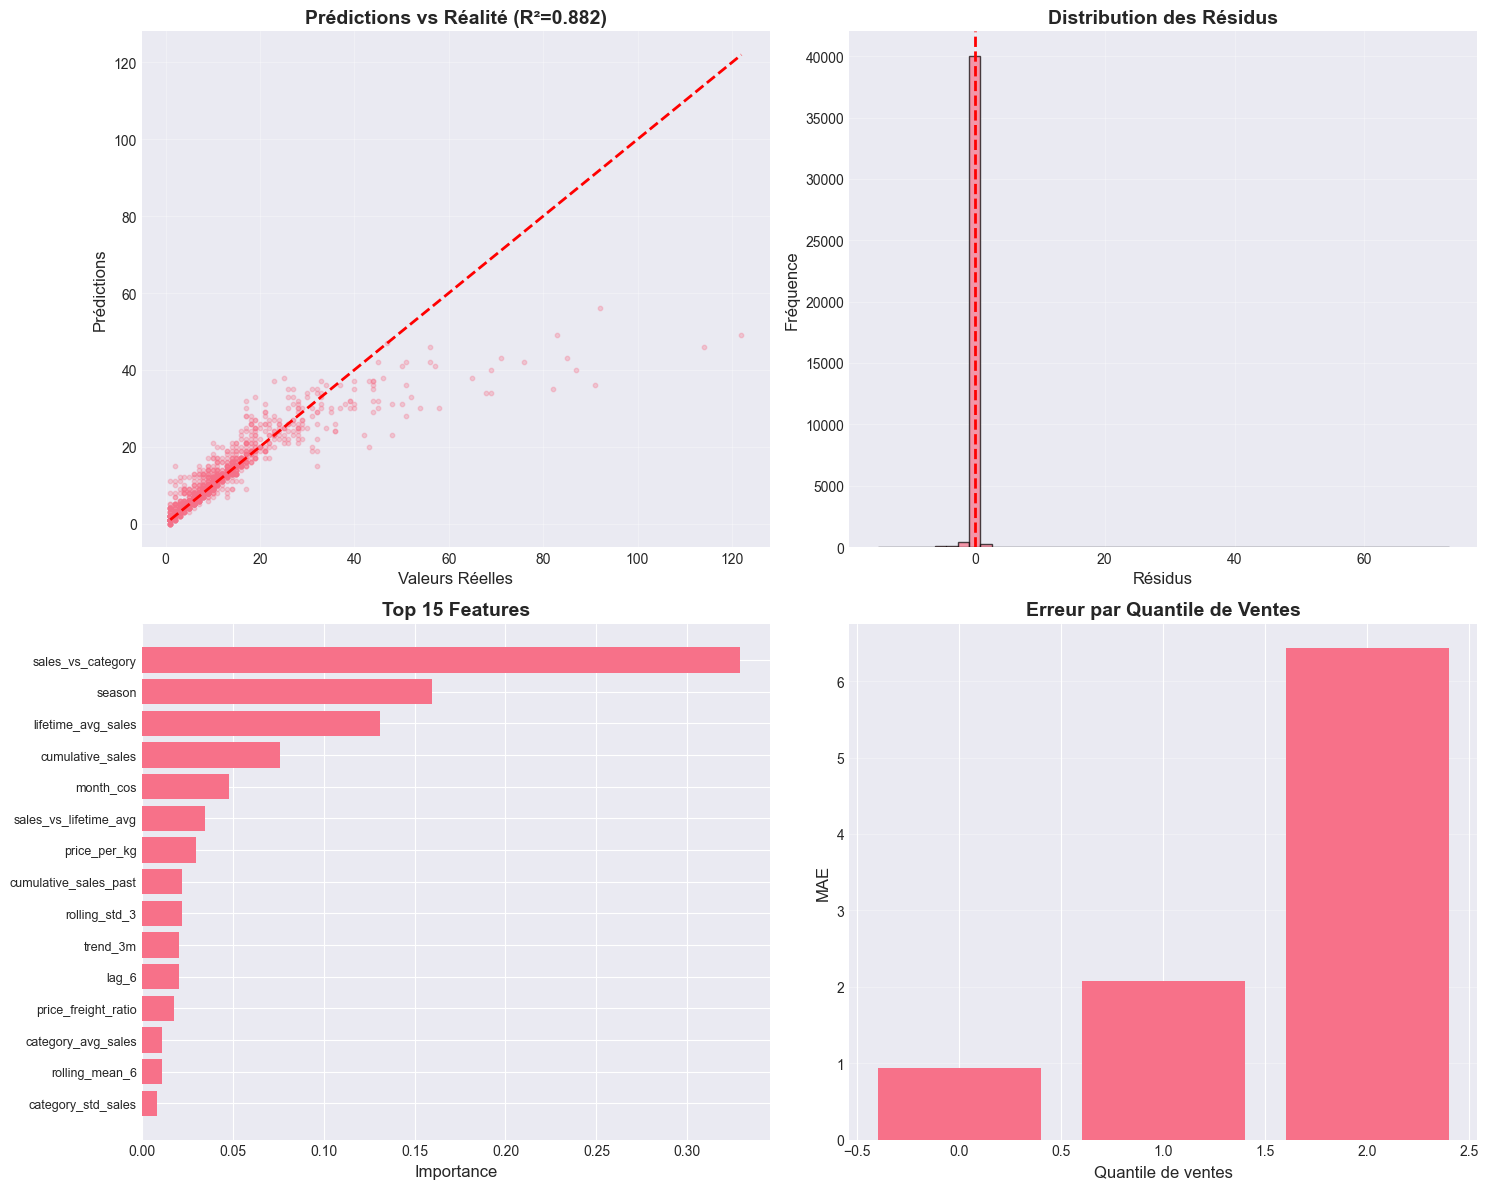

✓ Visualisations sauvegardées: model_evaluation_corrected.png


In [94]:
# Figure 1: Évaluation du modèle
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Prédictions vs Réalité
axes[0, 0].scatter(y_test, y_pred_squared_int, alpha=0.3, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valeurs Réelles', fontsize=12)
axes[0, 0].set_ylabel('Prédictions', fontsize=12)
axes[0, 0].set_title(f'Prédictions vs Réalité (R²={r2_squared:.3f})', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Résidus
residuals = y_test - y_pred_squared_int
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Résidus', fontsize=12)
axes[0, 1].set_ylabel('Fréquence', fontsize=12)
axes[0, 1].set_title('Distribution des Résidus', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].grid(True, alpha=0.3)

# Feature Importance
top_features = feature_importance.head(15)
axes[1, 0].barh(range(len(top_features)), top_features['importance'].values)
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'].values, fontsize=9)
axes[1, 0].set_xlabel('Importance', fontsize=12)
axes[1, 0].set_title('Top 15 Features', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()

# Erreur par quantile
y_test_sorted = y_test.sort_values()
quantiles = pd.qcut(y_test_sorted, q=10, duplicates='drop')
error_by_quantile = []
for q in quantiles.cat.categories:
    mask = quantiles == q
    error_by_quantile.append(mean_absolute_error(y_test[mask], y_pred_squared_int[mask]))

axes[1, 1].bar(range(len(error_by_quantile)), error_by_quantile)
axes[1, 1].set_xlabel('Quantile de ventes', fontsize=12)
axes[1, 1].set_ylabel('MAE', fontsize=12)
axes[1, 1].set_title('Erreur par Quantile de Ventes', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_evaluation_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualisations sauvegardées: model_evaluation_corrected.png")

# ============================================================================
# SAUVEGARDE DU MODÈLE POUR PRODUCTION
# ============================================================================

In [95]:
import pickle
import json
import os
from datetime import datetime

# Créer le dossier pour les modèles
model_dir = "../streamlit_app/models/orders_forecast"
os.makedirs(model_dir, exist_ok=True)

print("💾 Sauvegarde du modèle de prédiction des commandes...")

# 1. Sauvegarder le modèle XGBoost
model_path = os.path.join(model_dir, "xgboost_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(model_squared, f)
print(f"✅ Modèle XGBoost sauvegardé: {model_path}")

# 2. Sauvegarder la liste des features
features_path = os.path.join(model_dir, "feature_names.pkl")
with open(features_path, 'wb') as f:
    pickle.dump(feature_cols, f)
print(f"✅ Liste des features sauvegardée: {features_path}")

# 3. Sauvegarder les meilleurs paramètres
params_path = os.path.join(model_dir, "best_params.json")
# Convertir tous les paramètres en types sérialisables
best_params_serializable = {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                            for k, v in best_params.items()}
with open(params_path, 'w') as f:
    json.dump(best_params_serializable, f, indent=2)
print(f"✅ Paramètres sauvegardés: {params_path}")

# 4. Sauvegarder les données de test pour validation
test_data_path = os.path.join(model_dir, "test_data.pkl")
test_data_sample = {
    'X_test': X_test.head(1000),  # Échantillon pour tests
    'y_test': y_test.head(1000),
    'products_sample': products.head(100)
}
with open(test_data_path, 'wb') as f:
    pickle.dump(test_data_sample, f)
print(f"✅ Données de test sauvegardées: {test_data_path}")

print("\n✨ Sauvegarde terminée avec succès!")

💾 Sauvegarde du modèle de prédiction des commandes...
✅ Modèle XGBoost sauvegardé: ../streamlit_app/models/orders_forecast\xgboost_model.pkl
✅ Liste des features sauvegardée: ../streamlit_app/models/orders_forecast\feature_names.pkl
✅ Paramètres sauvegardés: ../streamlit_app/models/orders_forecast\best_params.json
✅ Données de test sauvegardées: ../streamlit_app/models/orders_forecast\test_data.pkl

✨ Sauvegarde terminée avec succès!


In [96]:
# 5. Sauvegarder les métadonnées et métriques du modèle
config = {
    "model_name": "XGBoost Orders Forecast",
    "model_type": "orders_prediction",
    "trained_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "algorithm": "XGBoost Regressor",
    
    # Informations sur les données
    "data_info": {
        "n_train_samples": len(train_data),
        "n_test_samples": len(test_data),
        "n_features": len(feature_cols),
        "cutoff_date": cutoff_date,
        "train_period": f"{train_data['order_month'].min()} à {train_data['order_month'].max()}",
        "test_period": f"{test_data['order_month'].min()} à {test_data['order_month'].max()}"
    },
    
    # Métriques de performance
    "metrics": {
        "mae": float(mae_squared),
        "r2_score": float(r2_squared),
        "r2_train": float(r2_squared1)
    },
    
    # Paramètres du modèle
    "hyperparameters": best_params_serializable,
    
    # Features utilisées
    "features": {
        "total_features": len(feature_cols),
        "top_10_features": feature_importance.head(10)['feature'].tolist(),
        "feature_categories": {
            "temporal": ["month", "year", "quarter", "season", "month_sin", "month_cos"],
            "lags": [f"lag_{i}" for i in [1, 2, 3, 6, 12]],
            "rolling": [f"rolling_mean_{w}" for w in [3, 6, 12]],
            "product": ["price", "product_weight_g", "product_volume_cm3", "product_density"],
            "special_events": ["is_black_friday", "is_christmas", "is_end_year"]
        }
    },
    
    # Informations pour la prédiction
    "prediction_info": {
        "target": "quantity_sold",
        "unit": "unités vendues par mois",
        "requires_features": feature_cols[:10],  # Top 10 features critiques
        "output_type": "integer (arrondi, min=0)"
    }
}

config_path = os.path.join(model_dir, "config.json")
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

print(f"✅ Configuration et métriques sauvegardées: {config_path}")

# Afficher un résumé
print("\n📊 RÉSUMÉ DU MODÈLE SAUVEGARDÉ:")
print(f"  • Échantillons d'entraînement: {len(train_data):,}")
print(f"  • Échantillons de test: {len(test_data):,}")
print(f"  • Nombre de features: {len(feature_cols)}")
print(f"  • MAE sur test: {mae_squared:.4f}")
print(f"  • R² sur test: {r2_squared:.4f}")
print(f"  • R² sur train: {r2_squared1:.4f}")
print(f"\n  🎯 Top 5 features importantes:")
for i, row in feature_importance.head(5).iterrows():
    print(f"     {i+1}. {row['feature']:30s} (importance: {row['importance']:.4f})")

✅ Configuration et métriques sauvegardées: ../streamlit_app/models/orders_forecast\config.json

📊 RÉSUMÉ DU MODÈLE SAUVEGARDÉ:
  • Échantillons d'entraînement: 21,199
  • Échantillons de test: 40,977
  • Nombre de features: 40
  • MAE sur test: 0.0775
  • R² sur test: 0.8819
  • R² sur train: 0.9986

  🎯 Top 5 features importantes:
     35. sales_vs_category              (importance: 0.3289)
     15. season                         (importance: 0.1596)
     38. lifetime_avg_sales             (importance: 0.1309)
     37. cumulative_sales               (importance: 0.0761)
     14. month_cos                      (importance: 0.0477)
